In [1]:
# Done by Waren Long
# waren@sourced.tech
# 01/06/2017

In [2]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import time
import copy

from pyemd import emd_with_flow

Populating the interactive namespace from numpy and matplotlib


In [3]:
# https://drive.google.com/open?id=0B-w8jGUJto0iTHdzMVlTVTVSMW8

In [ ]:
with open("output.pickle", "rb") as fin:
    dataset = pickle.load(fin)
nb_users = len(dataset)

In [5]:
with open("langs.pickle", "rb") as fin:
    langs = pickle.load(fin)
nb_langs = len(langs)

In [6]:
dataset[51]

((8, ((2014, 6824), (2015, 879))),
 (11, ((2014, 48), (2015, 1572))),
 (21, ((2014, 11920), (2015, 17269))),
 (22, ((2014, 1186),)))

# Filtering and quantizing the dataset

In [7]:
#Consider users who has only coded between 2000 and 2017

for user, global_coding in enumerate(dataset):
    for lang, code_in_lang in global_coding:
        for year,qtt_coded in code_in_lang:
            if year < 2000 or year > 2017:
                del dataset[user]

### Quantization of contributions 

In [8]:
values = []
for user in dataset:
    for lang in user:
        for year in lang[1]:
            values.append(year[1])
            
values = array(values)

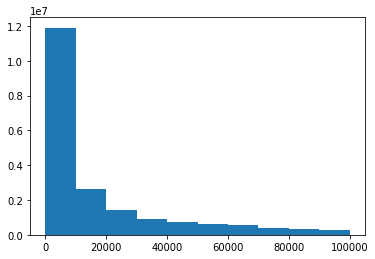

In [9]:
_, bins, _ = hist(values[values < 100000])

In [10]:
from sklearn.neighbors.kde import KernelDensity

kde = KernelDensity(kernel='cosine', bandwidth=0.2).fit(values[:, newaxis])

In [12]:
estimated = exp(kde.score_samples(arange(0, 100000, 1000)[:,newaxis]))

In [13]:
s1 = trapz(estimated, arange(0, 100000, 1000))
freq, bins = histogram(values[values < 100000], bins=bins)
s2 = trapz(freq, bins[:-1])
s1, s2 

(2.6793318412661389, 135942506095.5)

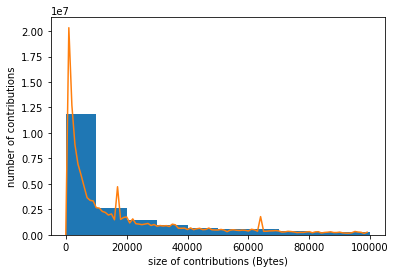

In [14]:
hist(values[values < 100000])
plot(arange(0, 100000, 1000), estimated * s2 / s1)
ylabel("number of contributions")
xlabel("size of contributions (Bytes)")
savefig("contributions.svg")

In [15]:
#9-partition of contributions
y = estimated * s2 / s1
y = y[1:]
elem_area = trapz(y)/10
xi = [0]

for k in range(9):
    i = 0
    while (trapz(y[xi[k]:xi[k]+i+1]) < elem_area) & (xi[k]+i<100):
        i += 1
    xi.append(xi[k]+i)
    
print(xi)

classified_values = np.zeros(len(xi))

for i in range(len(xi)):
    classified_values[i] = i
classified_values

[0, 1, 3, 6, 11, 17, 27, 44, 70, 100]


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [16]:
#return the value of the class where belong the contribution "val"
def stairvalue(value):
    idx = np.searchsorted(xi, value/1000) 
    return classified_values[idx-1]*1000

stairvalue(7489)

3000.0

# Get the transion matrices with EMD

In [17]:
# Return the transition matrix of user, between a previous year and the following one
def get_transition_matrix_pyemd(user, pre_year):
    
    # Get the reactors of user for the previous and following year
    reactors = zeros((len(lang2keep),2), order='f')
    
    for ind, code_in_lang in enumerate(dataset[user]):
        lang = code_in_lang[0]
                     
        if lang in lang2keep:
            for year,qtt_coded_year in code_in_lang[1]:
                if year == pre_year:
                    reactors[lang2keep.index(lang),0] = stairvalue(qtt_coded_year)

                elif year == pre_year+1:
                    reactors[lang2keep.index(lang),1] = stairvalue(qtt_coded_year)

    # Normalization of reactors 
    if (sum(reactors[:,0]) == 0) or (sum(reactors[:,1]) == 0):
        P = zeros((len(lang2keep), len(lang2keep)))
        return P
    
    else: 
        for i in [0, 1]:
            reactors[:,i] = [j/sum(reactors[:,i]) for j in reactors[:,i]]

    distance = np.ones((len(lang2keep), len(lang2keep)))
    dist, P = emd_with_flow(reactors[:,0], reactors[:,1], distance)
    P = np.asarray(P)
   
    return P

In [18]:
#return 1 if we need to compute the transition matrix for a given user, year
#return 0 otherwise
def existing_matrix(user, year):

    years_coding = []
    for ind, code_in_lang in enumerate(dataset[user]):
        for y,qtt_coded_year in code_in_lang[1]:
            if y not in years_coding:
                years_coding.append(y)
                
    years_coding.sort()
                
    if len(years_coding) == 1:
        return 0
                    
    elif year not in years_coding[:-1]:
        return 0
            
    else:
        return 1

In [19]:
# Filtering users and years, take 2 min
#Consider users who has used more than 1 language

nb_users = len(dataset)
years2study = [2000 + i for i in range(17)]
#[2016]
[2000 + i for i in range(17)]
#[2013, 2014, 2015]
all_years = []
all_users = []

for user in range(nb_users):
    for year in years2study:
        if existing_matrix(user, year) == 1:
            all_users.append(user)
            all_years.append(year)
            
len(all_users)

2707982

## Proportion of people who ever tried JavaScript 

In [20]:
user_js = 0
for user, global_coding in enumerate(dataset):
    for lang, code_in_lang in global_coding:
        for year,qtt_coded in code_in_lang:
            if lang == langs["JavaScript"]:
                user_js += 1
                break
user_js / len(dataset)

0.39969415892590043

In [21]:
# 22 programming languages to focus on
# choice of excluding JavaScript (cf blog post)
lang2keep = [1,2,3,4,5,10,12,16,22,24,28,30,40,44,52,62,64,68,77,80,85,87]
lang2remove = [i for i in range(nb_langs)]

for i in lang2keep:
    lang2remove.remove(i)

In [22]:
# multiprocessing to get the transitions matrices
from multiprocessing import Lock, Array
matrix_lock = Lock()
global_mem = [Array("f", len(lang2keep) * len(lang2keep)) for _ in range(len(years2study))]

def process_transition_matrix(userid, year):
    matrix = get_transition_matrix_pyemd(userid, year)
    P_global_pyemd = frombuffer(global_mem[year - min(years2study)].get_obj(), dtype=float32).reshape((len(lang2keep), len(lang2keep)))
    with matrix_lock:
        P_global_pyemd += matrix

In [23]:
from multiprocessing import Pool

P_global_pyemd = [frombuffer(global_mem[year].get_obj(), dtype=float32).reshape((len(lang2keep), len(lang2keep)))
                  for year in range(len(years2study))]
for m in P_global_pyemd:
    m[:] = 0

with Pool(processes=12) as pool:
    pool.starmap(process_transition_matrix, zip(all_users, all_years))

# Final treatments and normalization

In [24]:
to_langs = {v: k for k, v in langs.items()}
to_langs[1]

'C++'

In [25]:
#reshape language dictionnaries
to_langs_22 = copy.deepcopy(to_langs)

for lang in lang2remove:
    del to_langs_22[lang]
    
langs_22 = {v: k for k, v in to_langs_22.items()}
langs_22

{'C': 5,
 'C#': 16,
 'C++': 1,
 'Clojure': 52,
 'Erlang': 80,
 'FORTRAN': 64,
 'Go': 24,
 'Haskell': 87,
 'Java': 22,
 'Lua': 62,
 'Matlab': 85,
 'Objective-C': 40,
 'PHP': 3,
 'Pascal': 44,
 'Perl': 4,
 'Python': 2,
 'R': 30,
 'Ruby': 12,
 'Rust': 77,
 'Scala': 10,
 'Swift': 28,
 'Visual Basic': 68}

In [26]:
qtt_coded = zeros(len(lang2keep))

for user, global_coding in enumerate(dataset): 
    for lang, code_in_lang in global_coding:
        for year,qtt_coded_lang in code_in_lang:
            if lang in lang2keep:
                qtt_coded[lang2keep.index(lang)] += qtt_coded_lang

In [27]:
df_langs = pd.DataFrame.from_dict(to_langs_22, orient="index")
df_langs = df_langs.reset_index(drop=True)
df_langs.columns = ["Languages"]

df_qtt_coded = pd.DataFrame(qtt_coded, columns =["Bytes"])
df_qtt_coded_lang = pd.concat([df_langs, df_qtt_coded], axis=1)

In [28]:
P_global = sum(P_global_pyemd, 0)

In [29]:
P_global_norm = copy.deepcopy(P_global)
np.fill_diagonal(P_global_norm, 0)

In [30]:
# row normalization
row_sums = P_global_norm.sum(axis=1)
for j in range(len(lang2keep)): 
    if row_sums[j]!= 0:
        P_global_norm[j,:] = P_global_norm[j,:] / row_sums[j]

# Power Iteration

In [31]:
# power iteration algorithm
def power_iteration(A, nb_iterations=100, beta=0.85):
    u = np.random.rand(len(lang2keep))
    u = np.reshape(u, (len(lang2keep), 1))
    A = A * beta + ((1 - beta) / len(lang2keep)) * np.ones((len(lang2keep), len(lang2keep)))
    
    for _ in range(nb_iterations):
        u_next = np.dot(A,u)
        u_next_norm = sum(u_next)
        u = u_next / u_next_norm
                
    return u

In [32]:
# compute eigenvector of the transition matrix 
ev = power_iteration(P_global_norm.T)
df_ev = pd.DataFrame(ev, columns =["Popularity"])
df_ev = pd.concat([df_langs, df_qtt_coded, df_ev], axis=1)
df_ev = df_ev.sort_values(by="Popularity", ascending=False)
df_ev = df_ev.reset_index(drop=True)
df_ev

,Languages,Bytes,Popularity
0,Python,2.627407e+11,0.161064
1,Java,3.869482e+11,0.152582
2,C,3.994752e+11,0.092047
3,C++,2.934073e+11,0.091768
4,PHP,5.679765e+11,0.084963
5,Ruby,6.015095e+10,0.082822
6,C#,1.516803e+11,0.060739
7,Objective-C,7.564807e+10,0.039697
8,Go,1.667947e+10,0.031934
9,Swift,8.537804e+09,0.026259


# Visuals Sum of all matrices

In [33]:
# from Erik's code 
# function to visualize a transition matrix

def plot_mat(m, items, cm, fn, fmt, dir_text=None):
    
    s = 4 + len(items) * 0.3
    fig = pyplot.figure(figsize=(s, s))
    ax = fig.add_subplot(111)
    ax.xaxis.set_label_position('top')
    ax.matshow(m + 1, cmap=cm, norm=matplotlib.colors.LogNorm(vmin=numpy.min(m+1), vmax=numpy.max(m+1)))

    if dir_text:
        ax.set_xlabel('To language\n< Smaller %s %10s Larger %s >' % (dir_text, '', dir_text))
        ax.set_ylabel('From language\n< Larger %s %10s Smaller %s >' % (dir_text, '', dir_text))
    else:
        ax.set_xlabel('To language')
        ax.set_ylabel('From language')
    ax.set_xticks(numpy.arange(0, len(items)))
    ax.set_yticks(numpy.arange(0, len(items)))
    ax.set_xticklabels(items, rotation=90, ha='center')
    ax.set_yticklabels(items, va='center')
    ax.set_xticks(numpy.arange(0.5, len(items)+0.5), minor=True)
    ax.set_yticks(numpy.arange(0.5, len(items)+0.5), minor=True)
    ax.grid(which='minor')

    for i in range(len(items)):
        for j in range(len(items)):
            text = fmt % m[i][j]
            if text != fmt % 0:
                ax.text(j, i, text, va='center', ha='center', size=7)

    fig.tight_layout()
    pyplot.savefig(fn, dpi=300)

### Reshape transition matrices and dictionaries so that it is comparable with Erik's work 

In [34]:
# expand the transition matrix with 0 in the rows/columns correponding to
# the 3 languages we don't have in our dataset
P_global_25 = P_global
for i in range(3):
    li_zer = zeros((1,P_global_25.shape[0]))
    col_zer = zeros((P_global_25.shape[0]+1, 1))
    P_global_25 = np.append(P_global_25, li_zer, 0)
    P_global_25 = np.append(P_global_25, col_zer, 1)

P_global_25.shape

(25, 25)

In [35]:
langs_25 = copy.deepcopy(langs_22)
langs_25.update({"Lisp": 123, "Cobol": 124, "Kotlin": 125})

to_langs_25 = {v: k for k, v in langs_25.items()}

lang2keep_25 = copy.deepcopy(lang2keep)
for i in range(123, 126):
    lang2keep_25.append(i)

In [36]:
ps = sorted(range(len(langs_22)), key=lambda i: to_langs_22[lang2keep[i]])

# Erik's ordering + 3 languages (Lisp, Cobol, Kotlin) so that it makes matricx comparaison easier
ps_erik = [4, 7, 0, 14, 23, 19, 16, 9, 21, 8, 24, 22, 15, 20, 12, 2, 13, 3, 1, 11, 6, 18, 5, 10, 17]

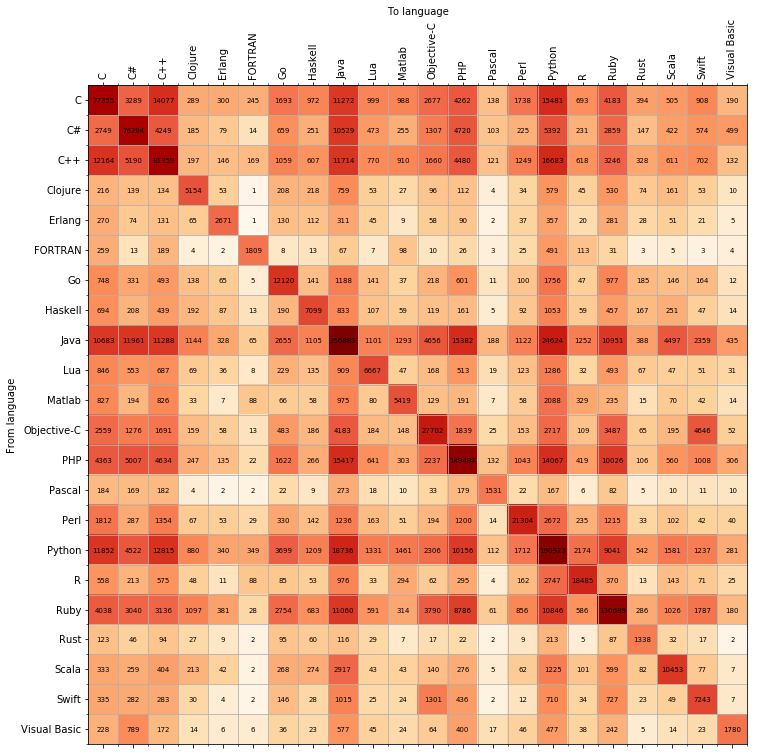

In [39]:
# 22 languages
plot_mat(P_global[ps,:][:,ps], sorted(langs_22), pyplot.cm.OrRd, 'sum_matrix_22lang.svg', '%.0f')
# 25 languages
#plot_mat(P_global_25[ps_erik,:][:,ps_erik], sorted(langs_25), pyplot.cm.OrRd, 'tsum_matrix__25lang.svg', '%.0f')

In [40]:
# Erik's ordering so that it makes matricx comparaison easier
pst_erik = [22, 3, 17, 16, 15, 13, 23, 24, 20, 14, 11, 10, 6, 5, 12, 19, 2, 21, 18, 7, 1, 0, 8, 4, 9]

# ordering based on our dominant eigenvector
pst = sorted(range(len(lang2keep)), key=lambda i: ev[i])

In [41]:
for p in reversed(pst):
    print('| %5.2f%% | %20s |' % (ev[p]*100, to_langs_22[lang2keep[p]]))

| 16.11% |               Python |
| 15.26% |                 Java |
|  9.20% |                    C |
|  9.18% |                  C++ |
|  8.50% |                  PHP |
|  8.28% |                 Ruby |
|  6.07% |                   C# |
|  3.97% |          Objective-C |
|  3.19% |                   Go |
|  2.63% |                Swift |
|  2.24% |                Scala |
|  1.97% |                 Perl |
|  1.80% |                    R |
|  1.79% |              Haskell |
|  1.73% |                  Lua |
|  1.65% |               Matlab |
|  1.51% |              Clojure |
|  1.20% |                 Rust |
|  1.03% |               Erlang |
|  1.00% |         Visual Basic |
|  0.86% |              FORTRAN |
|  0.82% |               Pascal |


In [42]:
# expand the transition matrix with 0 in the rows/columns correponding to
# the 3 languages we don't have in our dataset
P_global_norm_25 = P_global_norm
for i in range(3):
    li_zer = zeros((1,P_global_norm_25.shape[0]))
    col_zer = zeros((P_global_norm_25.shape[0]+1, 1))
    P_global_norm_25 = np.append(P_global_norm_25, li_zer, 0)
    P_global_norm_25 = np.append(P_global_norm_25, col_zer, 1)

P_global_norm_25.shape

(25, 25)

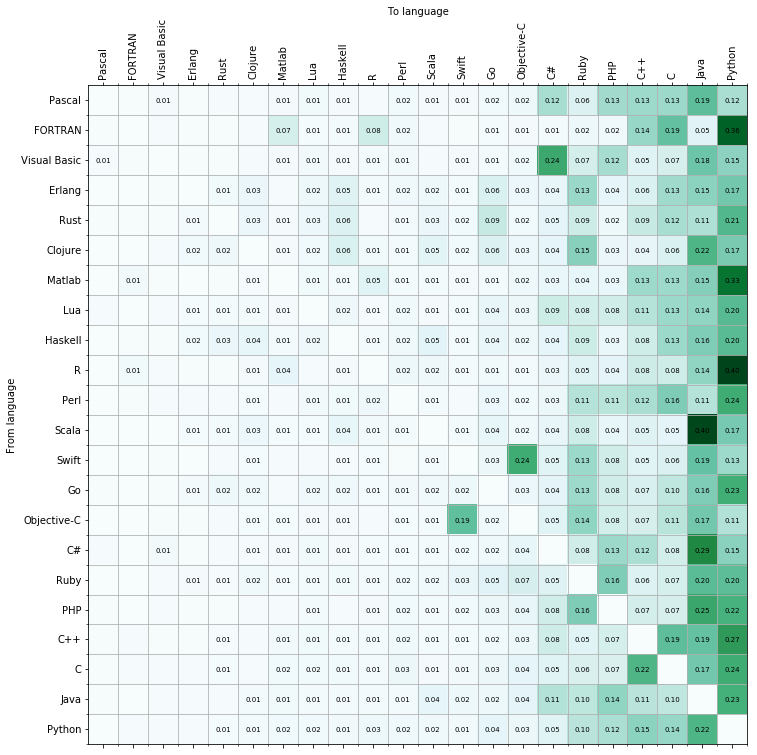

In [47]:
# 22 languages
plot_mat(P_global_norm[pst,:][:,pst], [to_langs_22[lang2keep[p]] for p in pst], pyplot.cm.BuGn, 'sum_matrix_22lang_eig.svg', '%.2f')
# 25 languages
#plot_mat(P_global_norm_25[pst_erik,:][:,pst_erik], [to_langs_25[lang2keep_25[p]] for p in pst_erik], pyplot.cm.BuGn, 'sum_matrix_25lang_eig.svg', '%.2f')

# Timeline

In [48]:
# setting diagonal values to 0
list_transition_matrices = copy.deepcopy(P_global_pyemd)

for i in range(len(list_transition_matrices)):
    np.fill_diagonal(list_transition_matrices[i], 0)

In [49]:
# row normalization

for i in range(len(list_transition_matrices)):
    row_sums = list_transition_matrices[i].sum(axis=1)
    for j in range(len(lang2keep)): 
        if row_sums[j]!= 0:
            list_transition_matrices[i][j,:] /= row_sums[j]

In [50]:
list_ev = []
list_df_ev = []
years = [2000 + i for i in range(16)]

for i in range(16):
    list_ev.append(power_iteration(list_transition_matrices[i].T))
    list_df_ev.append(pd.DataFrame(list_ev[i], columns =["Popularity"]))
    list_df_ev[i] = pd.concat([df_langs, list_df_ev[i]], axis=1)
    list_df_ev[i] = list_df_ev[i].sort_values(by="Popularity", ascending=False)
    list_df_ev[i] = list_df_ev[i].reset_index(drop=True)

Code to plot and save the 16 yearly transition matrices + their corresponding dominant eigenvector

In [51]:
#%matplotlib inline
#import pylab as pl
#from IPython import display

#for year in range(2000,2016):
#    filename = "P_" + str(year) + ".svg"
#    plot_mat(P_global_pyemd[year-2000][ps,:][:,ps], sorted(langs_22), pyplot.cm.OrRd, filename, '%.0f')
#    display.clear_output(wait=True)
#    display.display(pl.gcf())
#    time.sleep(1.0)

In [52]:
#list_pst = []
#for j in range(len(list_transition_matrices)):
#    list_pst.append(sorted(range(len(lang2keep)), key=lambda i: list_ev[j][i]))
#    print("------------------------------------")
#    print(years[j])
#    print("------------------------------------\n")
#    for p in reversed(list_pst[j]):
#        print('| %5.2f%% | %20s | %.0f' % (list_ev[j][p]*100, to_langs_22[lang2keep[p]], sorted(range(len(lang2keep)),reverse=True, key=lambda i: list_ev[j][i]).index(p)))

# Stack Area Plot

In [53]:
list_22lang = []
for key, lang in to_langs_22.items():
    list_22lang.append(lang)
    
list_22lang = np.asarray(list_22lang)

In [54]:
color_list = ["violet", "darkmagenta","thistle", "rebeccapurple",
              "mediumslateblue", "lightskyblue", 
              "navy", "lightblue",
              "teal", "mediumspringgreen", "g", "greenyellow", "olive",
              "khaki", "darkgoldenrod", "gold", 
              "darkorange", "peachpuff", "tomato",
              "firebrick", "rosybrown", "dimgray"]

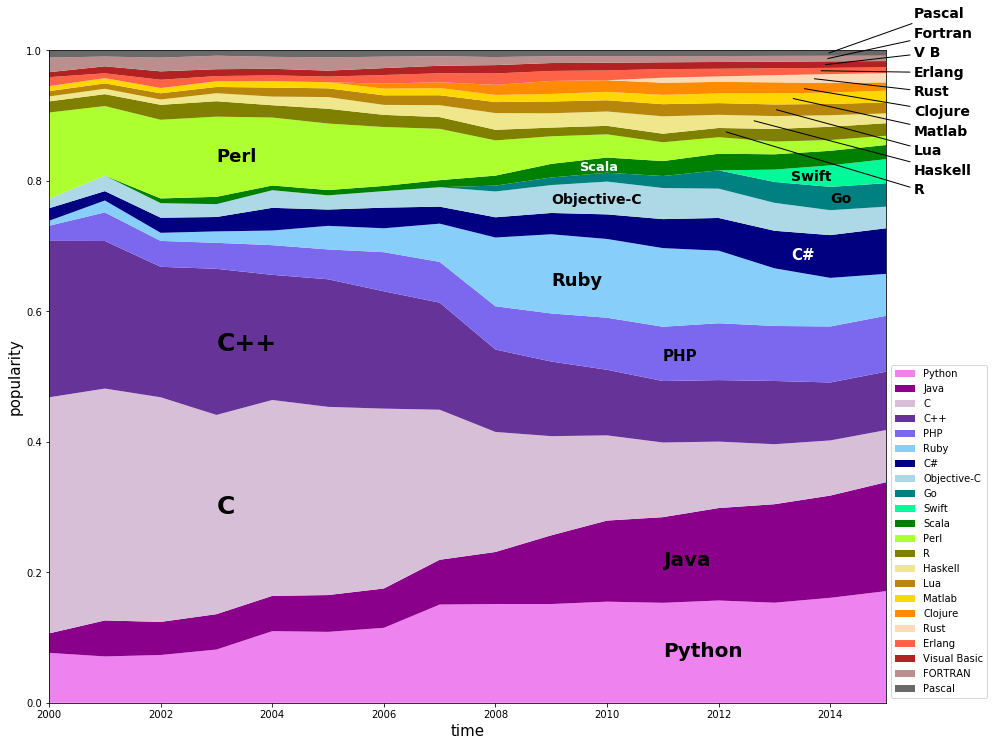

In [55]:
# Stack Area Plot
matrix_lang_years = np.zeros((len(lang2keep), len(years)))
for i in range(16):
    matrix_lang_years[:,i][:,np.newaxis] = np.asarray(list_ev[i][pst[::-1]], dtype = np.float32)
    
matrix_lang_years[17,:11] = 0 #rust launched in 2012
matrix_lang_years[16,:6] = 0 #clojure launched in 2007
matrix_lang_years[10,:2] = 0 #scala launched in 2003
matrix_lang_years[9,:13] = 0 #swift launched in 2014
matrix_lang_years[8,:8] = 0 #go launched in 2009

col_sums = matrix_lang_years.sum(axis=0)
for i in range(16): 
    matrix_lang_years[:,i] /= col_sums[i]


list_rowstack = []
for i in range(len(lang2keep)):
    list_rowstack.append(matrix_lang_years[i,:])


y = np.row_stack((list_rowstack))

pyplot.stackplot(years, y, labels=list_22lang[pst[::-1]], colors=color_list)

pyplot.legend(loc=3, fontsize=10, bbox_to_anchor=(1,0))
pyplot.ylabel("popularity", fontsize=15)
pyplot.xlabel("time", fontsize=15)

pyplot.tick_params(20)
pyplot.gcf().set_size_inches(15, 12)
annotate("C++", fontsize=25, xy=(2003, 0.54), weight = 'bold')
annotate("Python", fontsize=20, xy=(2011, 0.07), weight = 'bold')
annotate("PHP", fontsize=15, xy=(2011, 0.525), weight = 'bold')
annotate("Perl", fontsize=18, xy=(2003, 0.83), weight = 'bold')
annotate("C", fontsize=25, xy=(2003, 0.29), weight = 'bold')
annotate("Scala", color="white", fontsize=13, xy=(2009.5, 0.815), weight = 'bold')
annotate("Ruby", fontsize=18, xy=(2009, 0.64), weight = 'bold')
annotate("C#", color="white", fontsize=15, xy=(2013.3, 0.68), weight = 'bold')
annotate("Java", fontsize=20, xy=(2011, 0.21), weight = 'bold')
annotate("Swift", fontsize=14, xy=(2013.3, 0.801), weight = 'bold')
annotate("Go", fontsize=14, xy=(2014, 0.766), weight = 'bold')
annotate("Objective-C", fontsize=14, xy=(2009, 0.765), weight = 'bold')

annotate("R", fontsize=14, weight = 'bold', xy=(2012.1,0.876),
         xytext=(2015.5, 0.78),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Haskell", fontsize=14, weight = 'bold', xy=(2012.6,0.893),
         xytext=(2015.5, 0.81),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Lua", fontsize=14, weight = 'bold', xy=(2013,0.91),
         xytext=(2015.5, 0.84),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Matlab", fontsize=14, weight = 'bold', xy=(2013.3,0.927),
         xytext=(2015.5, 0.87),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Clojure", fontsize=14, weight = 'bold', xy=(2013.5,0.942),
         xytext=(2015.5, 0.9),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Rust", fontsize=14, weight = 'bold', xy=(2013.68,0.957),
         xytext=(2015.5, 0.93),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Erlang", fontsize=14, weight = 'bold', xy=(2013.8,0.969),
         xytext=(2015.5, 0.96),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("V B", fontsize=14, weight = 'bold', xy=(2013.88,0.978),
         xytext=(2015.5, 0.99),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Fortran", fontsize=14, weight = 'bold', xy=(2013.92,0.987),
         xytext=(2015.5, 1.02),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

annotate("Pascal", fontsize=14, weight = 'bold', xy=(2013.94,0.995),
         xytext=(2015.5, 1.05),
         arrowprops=dict(facecolor='black',arrowstyle="-"))

xlim(2000,2015)
ylim(0, 1)
savefig("eigenvect_stack_22lang.svg", transparent=True)